In [126]:
from pathlib import Path
import pandas as pd
from functools import partial
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from tqdm.notebook import tqdm, trange
import fiona
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time

In [130]:

def load_stats(json_file):
    with open(json_file, 'r') as file:
        n_params = json.load(file)
    mean_channels = np.array(n_params['mean'])
    std_channels = np.array(n_params['std'])
    return mean_channels, std_channels


def norm_img(img, mean_arr, std_arr):
    res = (np.transpose(img, (1, 2, 0)) - mean_arr) / std_arr
    return np.transpose(res, (2, 0, 1))


def get_tif_dims(tif_file):
    with rasterio.open(tif_file) as tif:
        n_ch = tif.count
        w = tif.width
        h = tif.height
    return n_ch, h, w


def add_padding(arr, pad_h, pad_w):
    n_ch, h, w = arr.shape
    
    plus_h = np.zeros((n_ch, pad_h, w))
    plus_w = np.zeros((n_ch, h+pad_h, pad_w))
    
    temp = np.concatenate((arr, plus_h), axis=1)
    return np.concatenate((temp, plus_w), axis=2)



class MulPanSharpenDataset(Dataset):
    def __init__(self, image_folder,
                 building_folder,
                 csv_data,
                 transforms=None):
        self.image_folder = image_folder
        self.building_folder = building_folder
        self.csv_data = csv_data
        self.transforms = transforms
    
    def __len__(self):
        return len(list(self.image_folder.iterdir()))
    
    def __getitem__(self, idx):
        file_img = list(self.image_folder.iterdir())[idx]
        
        img_id = "_".join(file_img.stem.split("_")[1:])
        no_building = self.csv_data[self.csv_data['BuildingId'] == -1]['ImageId'].unique().tolist()
        geojson_path = self.building_folder / f"buildings_{img_id}.geojson"

        # Extract the file as a (8 x 650 x 650) cube
        with rasterio.open(file_img) as tif:
            arr = tif.read()
            info = tif.meta
        
        info['count'] = 1
        # Extract geofeatures if the image has buildings
        if img_id in no_building:
            X = np.zeros((info['height'], info['width']), dtype='uint16')
            features = []
        else:
            with fiona.open(geojson_path, "r") as geojson:
                features = [feature["geometry"] for feature in geojson]
            X = np.ones((info['height'], info['width']), dtype='uint16')

        # Write polygons as a tif whose dimensions are the same than the opened tif
        with rasterio.open('temp.tif', 'w', **info) as new_ds:
            new_ds.write(X, 1)
        
        # Extract mask if necessary
        with rasterio.open('temp.tif') as tif:
            if features:
                mask_img, _ = mask(tif, features)
            else:
                mask_img = tif.read()

        arr= torch.from_numpy(arr.astype(np.int16)).float()
        mask_img = torch.from_numpy(mask_img.astype(np.int64)).long()
        
        
        if self.transforms:
            arr, mask_img = self.transforms(arr, mask_img)

        Path('temp.tif').unlink()

        return arr, mask_img.squeeze(0)

In [131]:
class SemSegCompose(nn.Module):
    def __init__(self, padding, mean_ch, std_ch, angle):
        super().__init__()
        self.pad = T.Pad(padding)
        self.norm = T.Normalize(mean_ch, std_ch)
        self.angle = angle
        
    def forward(self, img, mask_img):
        img, mask_img = self.pad(img), self.pad(mask_img)
        
        # random vertical flip
        if np.random.random() > 0.5:
            img, mask_img = TF.vflip(img), TF.vflip(mask_img)
            
        # random horizontal flip
        if np.random.random() > 0.5:
            img, mask_img = TF.hflip(img), TF.hflip(mask_img)
        
        # random rotation
        if np.random.random() > 0.5:
            angle = np.random.randint(-self.angle, self.angle)
            img, mask_img = TF.rotate(img, angle), TF.rotate(mask_img, angle)
            
        img = self.norm(img)
        return img, mask_img
            

In [129]:
np.random.random()

0.9805083935039599

In [132]:
img_folder=Path("../data/processed/train/data/MUL-PanSharpen/MUL-PanSharpen")
building_folder = Path("../data/processed/train/buildings")
df = pd.read_csv("../data/processed/train/Building_Solutions.csv")

mean_ch, std_ch = load_stats('../data/processed/stats_mul_pan.json')
padding = (3,3,3,3)
angle=360

transform = SemSegCompose(padding, mean_ch, std_ch, angle)
# padding=(6,6)
ds = MulPanSharpenDataset(img_folder, building_folder, df, transform)
# print(len(ds))

In [133]:
rand_idx = np.random.randint(len(ds))

arr, mask_img = ds[rand_idx]
arr.shape, mask_img.shape

(torch.Size([8, 656, 656]), torch.Size([656, 656]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


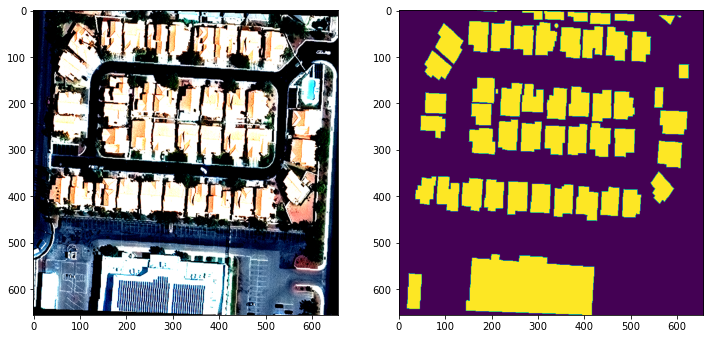

In [134]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))

ax1.imshow(arr.numpy().T[...,[4,2,1]])
ax2.imshow(mask_img.numpy().T)

In [128]:
t = torch.rand(8, 650, 650)

T.Pad(3)(t).shape

torch.Size([8, 656, 656])

In [98]:
bs = 8

dl = DataLoader(ds, batch_size=bs, shuffle=True)

arr, mask_img = iter(dl).next()

In [45]:
a = np.random.randint(1,size=(1,15,2), dtype=np.uint16)
print(a.dtype)
torch.from_numpy(a.squeeze().astype(np.int64)).long()

uint16


tensor([[0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]])

In [124]:
t_img.forward(arr)

AttributeError: 'Compose' object has no attribute 'forward'